In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as op
import shutil
from zipfile import ZipFile
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from utils import get_image_paths, word_from_image_path, preprocess_image, print_im, TextTransform, N_CHARS, SEQUENCE_LENGTH, IMAGE_DIMENSIONS
from multi_gpu import make_parallel

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Setting weights to GPU trained ones

In [65]:
from keras.models import Sequential, Model, load_model
cnn = load_model('p_model_0.h5')
cnn_empty = load_model('model_random_weights.keras')
all_weights = cnn.layers[5].get_weights()

In [66]:
saved_weights = {}
for i in range(5):
    saved_weights['convo{}'.format(i)] = [all_weights[i*2], all_weights[i*2+1]]
for i in range(3):
    saved_weights['dense_{}'.format(i+3)] = [all_weights[10 + i*2], all_weights[10+ i*2+1]]

In [67]:
layers_names = ['convo0',
'convo1',
'convo2',
'convo3',
'convo4',
'dense_3',
'dense_4',
'dense_5',]

In [94]:
# setting weights of each layers
for layer_name in layers_names:
    layer = cnn_empty.get_layer(name = layer_name)
    layer.set_weights(saved_weights[layer_name])

In [125]:
# Check weights have been set
np.array_equal(cnn_empty.get_layer(name = 'convo0').get_weights()[0] , saved_weights['convo0'][0] )

True

### Loading Images

In [117]:
from tqdm import tqdm, tqdm_notebook

##change path 
# base_dir = '/mnt/mjsynth/mnt/ramdisk/max/90kDICT32px/'
base_dir = '/mnt/c/Users/benoua/Google Drive/Master X - Data Sciences/2_Structured Data/Structured-Data/mjsynth'
images_paths = get_image_paths(base_dir)
#%%time
ims = []
errors_1, errors_2 = [], []
for i, im in enumerate(images_paths[:12]):
    try:
        ims.append(preprocess_image(img_to_array(load_img(im, grayscale=True))))
    except OSError:
        errors_1.append(i)

In [118]:
batch = np.stack(ims)

In [119]:

# %%time
batch = batch - batch.mean(axis=(1, 2)).reshape((-1, 1, 1))
batch = batch / batch.std(axis=(1, 2)).reshape((-1, 1, 1))
batch = batch.reshape(12, 32, 100, 1)
batch.shape

(12, 32, 100, 1)

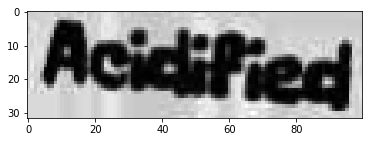

In [120]:
print_im(batch[5])

### Predictions

In [121]:
predictions = cnn_empty.predict(batch)

In [122]:
predictions[0].argmax(axis = 1)

array([19, 16, 12, 16, 17, 12, 12, 12, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28])

In [123]:
text_transformer = TextTransform()
print(text_transformer.word_from_matrix(predictions[4]))

m10ll77llssssssssssssss


In [157]:
from utils import NgramTransform

In [158]:
ngramtr = NgramTransform()

In [159]:
batch_y = ngramtr.make_batch_labels(images_paths[:12], False)
batch_y = batch_y.reshape(batch_y.shape[0], batch_y.shape[2]).astype(float)